In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using Distributions
using PyPlot
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/auxiliary/buffer.jl")
include("../functions/preprocessing.jl")

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


fft_expand (generic function with 1 method)

In [2]:
mutable struct AutoregressiveFilterbank <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function AutoregressiveFilterbank(y, x, θ, w; id=ForneyLab.generateId(AutoregressiveFilterbank))
        
        # ensure that the input arguments are random variables
        @ensureVariables(y, x, θ, w) 
        
        # create new object
        self = new(id, Array{Interface}(undef, 4), Dict{Symbol,Interface}())
        
        # add the node to the current factor graph
        ForneyLab.addNode!(currentGraph(), self)
        
        # add argument variables to interfaces of node
        self.i[:y] = self.interfaces[1] = ForneyLab.associate!(Interface(self), y)
        self.i[:x] = self.interfaces[2] = ForneyLab.associate!(Interface(self), x)
        self.i[:θ] = self.interfaces[3] = ForneyLab.associate!(Interface(self), θ)
        self.i[:w] = self.interfaces[4] = ForneyLab.associate!(Interface(self), w)
        
        # return object
        return self
    end
end

In [3]:
# add shortcut for calling the filter bank
slug(::Type{AutoregressiveFilterbank}) = "ARFB"

slug (generic function with 1 method)

In [4]:
function ruleVariationalARFBOutNPPP(marg_y::Nothing, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    mθ = ForneyLab.unsafeMean(marg_θ)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)
                        
    # calculate new parameters
    my = mθ .* mx
    wy = mw

    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wy*my, w=wy)

end

ruleVariationalARFBOutNPPP (generic function with 1 method)

In [5]:
function ruleVariationalARFBIn1PNPP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::Nothing, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})
    
    # caluclate required means
    my = ForneyLab.unsafeMean(marg_y)
    mθ = ForneyLab.unsafeMean(marg_θ)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vθ = ForneyLab.unsafeCov(marg_θ)

    # calculate new parameters
    wx = (vθ' + mθ*mθ') .* mw
    mx = inv(wx) * Diagonal(mθ) * mw * my

    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wx*mx, w=wx)

end

ruleVariationalARFBIn1PNPP (generic function with 1 method)

In [6]:
function ruleVariationalARFBIn2PPNP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::Nothing, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vx = ForneyLab.unsafeCov(marg_x)

    # calculate new parameters
    wθ = (vx' + mx*mx') .* mw
    mθ = inv(wθ) * Diagonal(mx) * mw * my

    # create variational message
    Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wθ*mθ, w=wθ)

end

ruleVariationalARFBIn2PPNP (generic function with 1 method)

In [7]:
function ruleVariationalARFBIn3PPPN(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::Nothing)

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mθ = ForneyLab.unsafeMean(marg_θ)

    # calculate required variances
    vy = ForneyLab.unsafeCov(marg_y)
    vx = ForneyLab.unsafeCov(marg_x)
    vθ = ForneyLab.unsafeCov(marg_θ)

    # calculate new parameters
    v = vy + my*my' - (mθ .* mx)*my' - my*(mx .* mθ)' + Diagonal(mθ)*vx*Diagonal(mθ) + Diagonal(mx)*vθ*Diagonal(mx)  + (mθ .* mx)*(mθ .* mx)' + vθ.*vx
    nu = size(v,1) + 2 

    # create variational message
    Message(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=inv(v), nu=nu)

end

ruleVariationalARFBIn3PPPN (generic function with 1 method)

In [8]:
@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (Nothing, ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBOutNPPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, Nothing, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBIn1PNPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, Nothing, ProbabilityDistribution),
                      :name          => VariationalARFBIn2PPNP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{ForneyLab.Wishart},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution, Nothing),
                      :name          => VariationalARFBIn3PPPN)


In [9]:
function generateARFB(nr_γ, bufsize)
    
    model = quote
        
        fg = FactorGraph()
        
        @RV [id=:smin] smin ~ GaussianMeanVariance(placeholder(:μ_smin, dims=(2*$nr_γ,)), placeholder(:Σ_smin, dims=(2*$nr_γ,2*$nr_γ)))
        @RV [id=:θ] θ ~ GaussianMeanVariance(placeholder(:μ_θ, dims=(2*$nr_γ,)), placeholder(:Σ_θ, dims=(2*$nr_γ,2*$nr_γ)))
        @RV [id=:w] w ~ ForneyLab.Wishart(placeholder(:v_w, dims=(2*$nr_γ,2*$nr_γ)), placeholder(:nu_w))
        @RV [id=:s] s ~ AutoregressiveFilterbank(smin, θ, w)
        @RV [id=:x] x = placeholder(:c, dims=($bufsize,2*$nr_γ)) * s
        @RV [id=:y] y ~ GaussianMeanVariance(x, placeholder(:Σ_x, dims=($bufsize,$bufsize)))
        placeholder(y, :y, dims=($bufsize,))
        
        q = PosteriorFactorization(smin, s, θ, w, ids=[:smin, :s, :θ, :w])

    end
    
end

generateARFB (generic function with 1 method)

In [10]:
# load speech data
xi, fs = wavread("../data/airco.wav", format="native")
fs = Int(fs)
xi = convert(Array{Float64,1}, xi[1*fs:4*fs])

# pre-process signals
yi = preprocess(xi, fs) 

N = length(yi)
t = collect(1:N)/8000
fs = 8000

audioplayers(yi, fs=8000);

<source src="data:audio/wav;base64,UklGRkB3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR3AQCsZgw+p76QPi+woD5FjbU+F4u1PmTHzD58EOo+RkkDP68iDT9uSgM/fvvdPlgozT5cGbw+RErRPjlKzz6kJMc+/Q6YPlbLjz4wAJI+jjquPnVEmD4Qyns+m7mBPu+gBj7PAi8+AvwiPq5FVbyWY0G+Eud+vkwLKL4wNr85DNvOPfZu+7sP6c69oz08vs+tA74t2Dy9eZkNviFKLL5ECIC+q0LNvqfC5b5Zjui+GfqSvv1emb6PMni+uFKbvmhQt74yJL6+ikftvhtDBr8ujP6+lfYJv2A/9b5XacS+GX5yvmTGZL6xk5e+wR6PvuE2b76Ga1q+SvO7vT1nVr11UFy8VkvKvUDbjL5KjKS+T/FbvjGhaL2sHnA9oNyhPOYblL1og6K9tQaLPXjsbT5OOmQ+F48+PhKelD3HVfY8o/CAPtUi6T6Dvwc/OIbcPoggnT5RuK8+w6H9Ph88Ij989Ck/23IKPzeTFz+YjSE/bmE1PwnEKj+sowg/Uuz1PsDU6T5DwOg+nP3pPr6Cvj5Cgoo+hlqKPi4JvT6BIas+3g4pPgaRn7xMnB+9BJymPIs87z2VFO88IIYDvvreq75+uta+bsyzvt3aUL4bgF2+tKCkvgnXyL7krOC+QlDsvh+F3b5x2dy+I3HVvpRRvb6sbre+smyqvpQjtr7owIG+i5h4vrJLg77gIl++vn9uvuAAg77KJVC+66iFvsqAhb4x/nq+lhJ7vjaVQb6xLQ2+7wOJvovf/L4zAhi/5d4Jv7PZ177oUIe+F1FVvmVAYL752bm+20e/vm6VuL6UrKq+2WhpvmVBCr6o8yK+OJTQvUN8iL3q7Ym9ercsObeKLj7VaaI+df7CPvLdxT6+QZs+XtOZPlMHxj7qcAM/EgUlP2GFKT8w7RA/rET/PqVrAD/1UiE/E9VCPxHIKj+7BAg/82e7PkFFoz6oZ64+yx/4Pg2PMz+hCD8/Du4wPxBoCj+4fQA/JpHePr1n7D7AbNY+HsKbPiyQbT6c8UE+O0s2PlYJBT4rWd48ToyNvQ4TXL4sFm++ZuFvvlNlhr6S67K+P4wBv9dSIr8xJB6/0SEKv3/U8r4obQe/tAEev1yMOb+3/TG/tyYav1L7G79Snye/x1QSv8OkB7+CguK+OvXevooz275V7dW++ca5vmGdkL7H1pS+glSIvrAVYL5yEzy+aPk2vskKJL7iCzK+3U26vRPsRL5oW9K9tG6VPR5TpT2+gvs8RejvvZV7QL0/p2C9GlCNuBxCTD6Wj2o+2+eJPT/sbLy42TU95K9hPpgkvz7Ak+o+7bLjPiDhqz6PC7o+hYDKPqPM2z5Ba9U+yNrNPvZPtj40C5c+uD1+PuIVrj5427g+/orWPtdH0T7xxbo++fWPPjZRRT4kjKs9JbY8PuGsfz6/dLE+iIqnPl1qSj5atfE9UDWfPejhaz4RXq4+F/y7PnfrqD7Q+JY964jPPO/Ppj2WOrs9pW+CPYvAtrw+PTO9kaN7vWUy2rvDab084jUSvQY1Eb771lG+XdBdvse2KL7gc02+Q8LmvhYNA7+QMBW/FDANv882877uVQq/srosvx/SS78Erjy/GBEtv1ZFFr/8I/m+TB4Sv4xBD79a9f++CrGUvuUKQr5JOE2+eVQovuOR+b2kCP67IT2iPcQ4xj3j4909DnskPq+xkT4wMqA+VN99PrbBIj4cPaU9kK59PXLCmT5NVb4+A1a7PipelD6yua89crFKPXwPlD3RfYg+Ce6kPrTzfT67618+kA+KPj38nT5Sr7s+e+LWPtgGyz53xas+76onPlc0lD64V7s+In7cPkgVzj4yWKw+z4V+Pnk/eT4WCpE+LL+FPqlsbT75nyI+k9b1Pa8uID4Q0/49D/MJPjCWEj7GOc09Eyi1Pb4mRz10XnI97HrRPLWLq712iwm+ecnIvUq8kr1v+Cy9b5WQu9T99b1uI06+HMJzvovfWb5lrdm97A89vrIIq752dty+W4Lmvj9qB78jugK/u54Bv19iA7+iXQO/O/UUv/zrKL+K8FO/9IxtvyIzXL/lkU2/HD8vv7y6Hr8zxxa/GikUv2GHAL9POdG+XBKgvsUmOL4dWvC9fc7JvXROxj1h8m8+dFDDPly4AD+IOOA+F5uzPi1MtT4ROsw+JcLyPgOiHz94uyM/GfgSPxwk8j7hW+U+awwTP3hyHz+QHhI/22z/PlNZ2z420fY+smEOPygnCD+UMPg+Kh+/PglKtz40bK4+uJXAPi1owj7IDqY+kICOPsJyoj7tXLI+N3CsPvXhaD7y/UI+B+VlPmvghT6AyKc+bbuHPnM3Kj6FV7y6cNrIvb8bjL2AwCG+phRlvh26ib51taa+B3NqvjZzVb7uFo6+cxjevvsaFL/+Awy/tXP/vuoBB78QZxq/T2Uuv6hiH7/h3AC/a9Sovsu/iL6Z18i+AtUNv2YJHL8C1AO/RKO/vob3pr71DZW+FI2cvvO6o76hNUi+cJo3vpUyQ778jBq+ryHbvQ7bjb1Osk69w8+qva5wTb6J5k2+FqBDvVhb9j0IUFM+eo34PWXp2j0wRdI8PQYIPgOVHj68EIA90kVLPdSodj3A9zM+suOOPltQoT6oNpc+gT+mPs62xj7RP/k+rPcZP/6mIj8ECwQ/64HmPpdH7j58tc4+MK4KP+TX8z4jw+A+saUEP1OMDz+u0Ac/TNYIP9r0Gz9FXgc/jMXxPm9jzT4kZZs+FJCUPscHtT4d3a0+slNVPjSIwz0zyTO89VQFvrfLBL4qo4K+rnB0vq4ok74Vx6K+YZ/MvmIbFL/4USe/+BUVv8PhAb9dAgi/76Ukv8W7Vb/932q/ilhjv+32Q7+G1g+/PhMGv7To/L7jPfC+p0rzvv5b4b4EtcW+Kbfmvgips75cvYq+xKQHvi/Ohb053tO998hNvnaxbL72Qxq+TkGHPd/9ZD2J+x+937vIvZFza72C9F09IJtRPjzxbT4hXD8+GkAlPiUEaT4V2Yo+4+LNPoyl9z7betQ+asvHPqNKzD7MFtc+ePubPqgbXD55QMs9T+9XPtQFuz57tP4+5MThPmnYmD6BXSA+pwFCPlCsuD6vheg+pdvpPgZg9z5tnOQ+1CwUP9i7Fj/IEBg/0In8PuWLuj4OW5w+UGe3PqxC9T4xtA0/PqX6Pshypz4boz8+uT4GPmCwJT7J0So+zHbpPa1U+bydbaC98b4Qvrx62LziwwA9SLpsPI2P7r09Xny+3ty6vnvNBr89JBi/+q0ev2XjF797XiK/zWwUv3HdC78UFRe/GJISv6QXDL9J8h2/eagmv4zaKL/j+y2/Z+pOv5aSTL8fpjK/R3stv8qqGb9rCPu+qY/vvu9Dxr5cV8u+/R7ivuJvrb49G56+E9WOvjexVr6h5VG+D03OvbuhuDwp4e49VzpuPi48gT5nF5Q+n5yVPjp8hD7dd6Y+Ala/PnT9rD7gIro+VS2xPvoDmT721s8+jgfIPgXD0T70Hrs+ubiaPki7NT46eg4+1SNHPeOkPj4XwZM+oWbEPlMMqz6hzmg+64OPPnTJuT4w3cE+p9GMPo+9Fz7qHm88unRmPnvJ4D4YWBU/g6MJP5Kzrz7VjAY+mhqHPX8z+j1Yv5s+U16iPrAzVD5Gtim9TB80vpdW7r2WfG89XDm9PU0cJL31fBK+P+Jivn3pnb7o7a2+RT/Cvs2M8b7PQAy/tBr2vuY+777ZjM++CRvKvmbB5b7RTOK+zl/3vlBWAb+n6/G+ZjX0voqMx76IPIq+gxBZvnLeKL5O8Ui+zOVDvvpFHTyyk4E+SHvTPvSpoz7SnBo+L+HzPHd+uTzrcCU+aBuhPp1Psj45tqw+87w/Pr1t8z29O4A+bZe+Pt6c2j6x0

In [29]:
f = collect(fs/10:fs/10:fs/2)
bufsize = 2*length(f)

# create fg
eval(generateARFB(length(f), bufsize))
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 16554177822462149343 -->
 16554177822462149343 
 
 × 
 multiplication_1 
 
<!-- 4699094576251938412 -->
 4699094576251938412 
 
 AutoregressiveFilterbank 
 autoregressivefilterbank_1 
 
<!-- 16554177822462149343--4699094576251938412 -->
 16554177822462149343--4699094576251938412 
 
 s 
 1 y 
 2 in1 
 
<!-- 17162599674252253327 -->
 17162599674252253327 
 
 placeholder_c 
 
<!-- 16554177822462149343--17162599674252253327 -->
 16554177822462149343--17162599674252253327 
 
 c 
 1 out 
 3 a 
 
<!-- 7714021821695810167 -->
 7714021821695810167 
 
 placeholder_nu_w 
 
<!-- 1579674799108983973 -->
 1579674799108983973 
 
 placeholder_v_w 
 
<!-- 17018406022213292904 -->
 17018406022213292904 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 16795125650227135004 -->
 16795125650227135004 
 
 placeholder_Σ_smin 
 
<!-- 17018406022213292904--16795125650227135004 -->
 17018406022213292904--16795125650227135004 
 
 Σ_smin 
 1 out 
 3 v 
 
<!-- 115807312381566379 -->
 115807312381566379 
 
 placeholder_μ_smin 
 
<!-- 17018406022213292904--115807312381566379 -->
 17018406022213292904--115807312381566379 
 
 μ_smin 
 1 out 
 2 m 
 
<!-- 10706880652859753801 -->
 10706880652859753801 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 10706880652859753801--16554177822462149343 -->
 10706880652859753801--16554177822462149343 
 
 x 
 1 out 
 2 m 
 
<!-- 9782541552029192067 -->
 9782541552029192067 
 
 placeholder_Σ_x 
 
<!-- 10706880652859753801--9782541552029192067 -->
 10706880652859753801--9782541552029192067 
 
 Σ_x 
 1 out 
 3 v 
 
<!-- 6241466119497286226 -->
 6241466119497286226 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 8351816178309368868 -->
 8351816178309368868 
 
 placeholder_μ_θ 
 
<!-- 6241466119497286226--8351816178309368868 -->
 6241466119497286226--8351816178309368868 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 13506904285368204431 -->
 13506904285368204431 
 
 placeholder_Σ_θ 
 
<!-- 6241466119497286226--13506904285368204431 -->
 6241466119497286226--13506904285368204431 
 
 Σ_θ 
 1 out 
 3 v 
 
<!-- 4699094576251938412--17018406022213292904 -->
 4699094576251938412--17018406022213292904 
 
 smin 
 1 out 
 2 x 
 
<!-- 4699094576251938412--6241466119497286226 -->
 4699094576251938412--6241466119497286226 
 
 θ 
 1 out 
 3 θ 
 
<!-- 3099049707470401235 -->
 3099049707470401235 
 
 W 
 wishart_1 
 
<!-- 4699094576251938412--3099049707470401235 -->
 4699094576251938412--3099049707470401235 
 
 w 
 1 out 
 4 w 
 
<!-- 3099049707470401235--7714021821695810167 -->
 3099049707470401235--7714021821695810167 
 
 nu_w 
 1 out 
 3 nu 
 
<!-- 3099049707470401235--1579674799108983973 -->
 3099049707470401235--1579674799108983973 
 
 v_w 
 1 out 
 2 v 
 
<!-- 7386419892505897815 -->
 7386419892505897815 
 
 placeholder_y 
 
<!-- 7386419892505897815--10706880652859753801 -->
 7386419892505897815--10706880652859753801 
 
 y 
 1 out 
 1 out

In [30]:
# generate algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))
println(source_code)

begin

function stepw!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBWishartOut(nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:v_w]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:nu_w]))
messages[2] = ruleVariationalARFBIn3PPPN(marginals[:s], marginals[:smin], marginals[:θ], nothing)

marginals[:w] = messages[1].dist * messages[2].dist

return marginals

end

function steps!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVariationalARFBOutNPPP(nothing, marginals[:smin], marginals[:θ], marginals[:w])
messages[2] = ruleSPMultiplicationOutNGP(nothing, messages[1], Message(MatrixVariate, PointMass, m=data[:c]))
messages[3] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:y]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_x]))
messages[4] = ruleSPMultiplication

In [67]:
yifft = FFTovertime(yi, bufsize, bufsize-1, rectangularwindow; pad=0)
yifftr = real.(yifft)
ρ = repeat([cor(yifftr[2:end,k], yifftr[1:end-1,k]) for k = 2:length(f)+1],inner=2)

10-element Array{Float64,1}:
 0.7825988485525122
 0.7825988485525122
 0.6061338837877844
 0.6061338837877844
 0.7180416550387004
 0.7180416550387004
 0.7266572591984328
 0.7266572591984328
 0.6870196548585723
 0.6870196548585723

In [68]:
μ_θ_mem = Array{Float64,2}(undef, N, 2*length(f))
Σ_θ_mem = Array{Float64,2}(undef, N, 2*length(f))
μ_x_mem = Array{Float64,1}(undef, N)
Σ_x_mem = Array{Float64,1}(undef, N)

# priors
μ_smin = zeros(2*length(f))
Σ_smin = 0.01*Ic(2*length(f))
μ_θ = ρ #ones(2*length(f))
Σ_θ = 1e-2*Ic(2*length(f))
v_w = 1e0*mean(abs2.(yi))*Ic(2*length(f))/length(f)
nu_w = 2*length(f) + 2
Σ_x = 1e-3*Ic(bufsize)

p = Progress(N-bufsize)
    marginals = Dict()

for n = bufsize:N
    
    next!(p)
    
    # fill marginals dictionary
    marginals[:smin] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_smin, v=Σ_smin)
    marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ, v=Σ_θ)
    marginals[:w] = ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=v_w, nu=nu_w)
    
    # fill data dictionary
    data = Dict()
    data[:μ_smin] = μ_smin
    data[:Σ_smin] = Σ_smin
    data[:μ_θ] = μ_θ
    data[:Σ_θ] = Σ_θ
    data[:v_w] = v_w
    data[:nu_w] = nu_w
    data[:c] = reshape( [cos.(2*pi*f*t[n-bufsize+1:n]') sin.(2*pi*f*t[n-bufsize+1:n]')]', bufsize, 2*length(f))#cos.(2*pi*f*t[n-bufsize+1:n]')'
    data[:Σ_x] = Σ_x*Ic(bufsize)
    data[:y] = yi[n-bufsize+1:n]   
    
    # make prediction
    messages = Array{Message}(undef, 4)
    Base.invokelatest(steps!, data, marginals, messages)
    μ_x_mem[n] = ForneyLab.unsafeMean(messages[2].dist)[end]
    Σ_x_mem[n] = ForneyLab.unsafeCov(messages[2].dist)[end,end]
    
    # perform updates
    for _ in 1:5
        Base.invokelatest(steps!, data, marginals)
        Base.invokelatest(stepθ!, data, marginals)
        Base.invokelatest(stepw!, data, marginals)
        Base.invokelatest(stepsmin!, data, marginals)
    end
    
    # update parameters
    μ_smin = ForneyLab.unsafeMean(marginals[:s])
    Σ_smin = ForneyLab.unsafeCov(marginals[:s])
    μ_θ = ForneyLab.unsafeMean(marginals[:θ])
    Σ_θ = ForneyLab.unsafeCov(marginals[:θ])
    v_w = marginals[:w].params[:v]
    nu_w = marginals[:w].params[:nu]

    # save parameters
    μ_θ_mem[n,:] = μ_θ
    Σ_θ_mem[n,:] = diag(Σ_θ)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


In [76]:
t

24001-element Array{Float64,1}:
 0.000125
 0.00025 
 0.000375
 0.0005  
 0.000625
 0.00075 
 0.000875
 0.001   
 0.001125
 0.00125 
 0.001375
 0.0015  
 0.001625
 ⋮       
 2.99875 
 2.998875
 2.999   
 2.999125
 2.99925 
 2.999375
 2.9995  
 2.999625
 2.99975 
 2.999875
 3.0     
 3.000125

In [75]:
reshape( [cos.(2*pi*f*t[1:5]') sin.(2*pi*f*t[1:5]')]', 5, 2*length(f))

5×10 reshape(::Adjoint{Float64,Array{Float64,2}}, 5, 10) with eltype Float64:
  0.809017  0.587785      0.309017  …   0.587785     -1.0   1.22465e-16
  0.309017  0.951057     -0.809017     -0.951057      1.0  -2.44929e-16
 -0.309017  0.951057     -0.809017      0.951057     -1.0   3.67394e-16
 -0.809017  0.587785      0.309017     -0.587785      1.0  -4.89859e-16
 -1.0       1.22465e-16   1.0          -4.89859e-16  -1.0   6.12323e-16

In [74]:
reshape( [cos.(2*pi*f*t[1]') sin.(2*pi*f*t[1]')]', 1, 2*length(f))

1×10 reshape(::Adjoint{Float64,Array{Float64,2}}, 1, 10) with eltype Float64:
 0.809017  0.587785  0.309017  0.951057  …  0.587785  -1.0  1.22465e-16

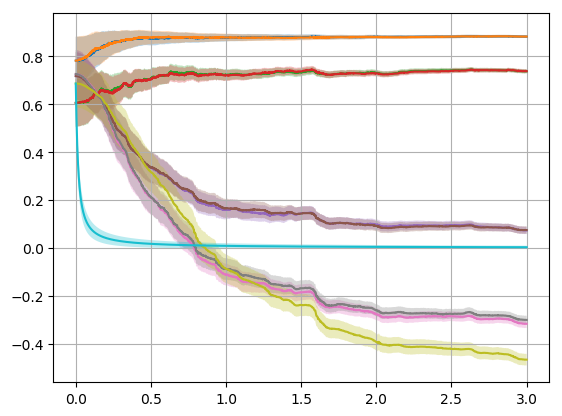

In [69]:
for k = 1:size(μ_θ_mem,2)
    plt.plot(t[bufsize:end], μ_θ_mem[bufsize:end,k])
    plt.fill_between(t[bufsize:end], μ_θ_mem[bufsize:end,k].+sqrt.(Σ_θ_mem[bufsize:end,k]), μ_θ_mem[bufsize:end,k].-sqrt.(Σ_θ_mem[bufsize:end,k]), alpha=0.3)
end
plt.grid()

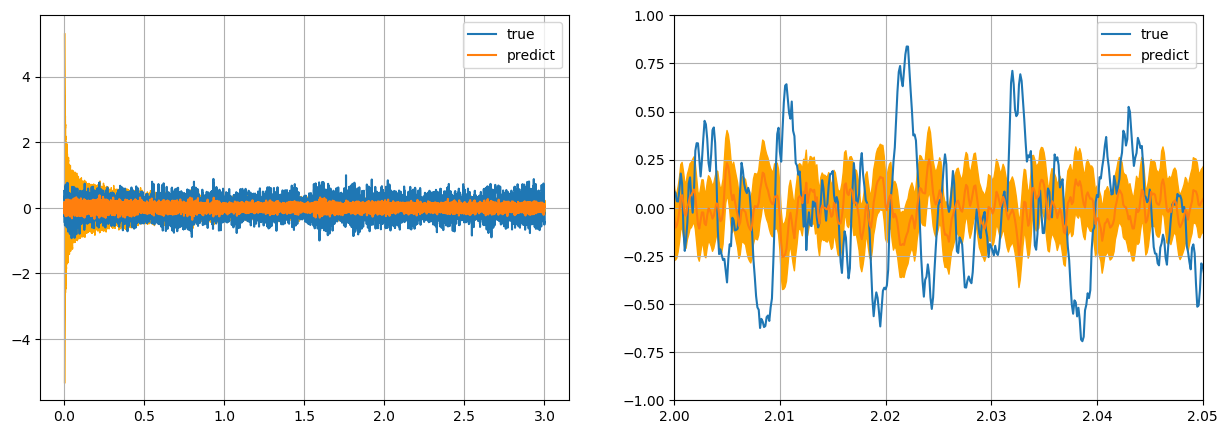

(nothing, PyObject <matplotlib.legend.Legend object at 0x0000000038B086D8>, (2, 2.05), (-1, 1))

In [70]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(t[bufsize:end], yi[bufsize:end], label="true")
ax[1].plot(t[bufsize:end], μ_x_mem[bufsize:end], label="predict")
ax[1].fill_between(t[bufsize:end], μ_x_mem[bufsize:end] .+ sqrt.(Σ_x_mem[bufsize:end]), μ_x_mem[bufsize:end] .- sqrt.(Σ_x_mem[bufsize:end]), color="orange")
ax[1].grid(), ax[1].legend()
ax[2].plot(t[bufsize:end], yi[bufsize:end], label="true")
ax[2].plot(t[bufsize:end], μ_x_mem[bufsize:end], label="predict")
ax[2].fill_between(t[bufsize:end], μ_x_mem[bufsize:end] .+ sqrt.(Σ_x_mem[bufsize:end]), μ_x_mem[bufsize:end] .- sqrt.(Σ_x_mem[bufsize:end]), color="orange")
ax[2].grid(), ax[2].legend(), ax[2].set_xlim(2,2.05), ax[2].set_ylim(-1,1)

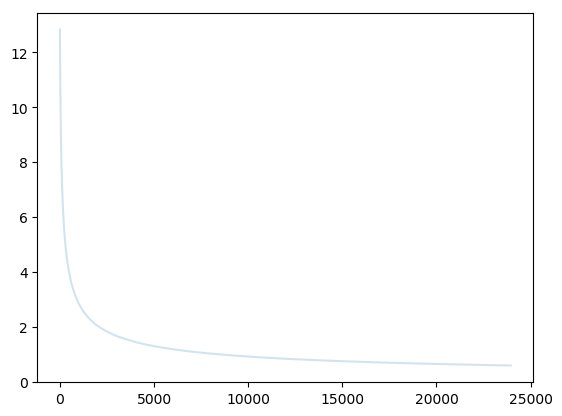

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000022CB0B8>

In [16]:
plt.plot(sqrt.(Σ_x_mem[bufsize:end]), alpha=0.2)

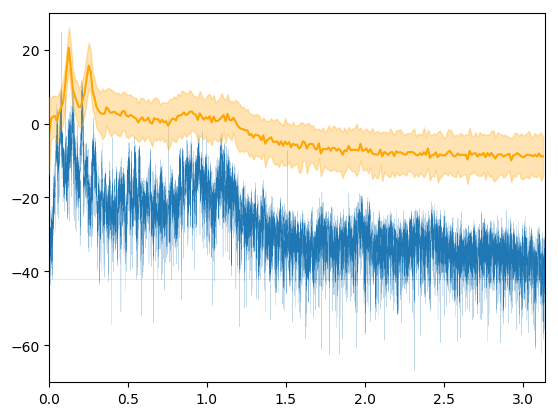

InterruptException: InterruptException:

In [ ]:
# generation:
Ni = 500 # (nr samples + frequency resolution)
Mi = 100 # nr of iterations

# get parameters
μ_θi, Σ_θi = ForneyLab.unsafeMean(marginals[:θ]), ForneyLab.unsafeCov(marginals[:θ])
v_wi, nu_wi = marginals[:w].params[:v], marginals[:w].params[:nu]


function generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    # create signal (option 1)
    sif = Array{Float64,2}(undef, 2*length(f), N)
    xif = Array{Float64,1}(undef, N)
    sif[:,1] = zeros(2*length(f))
    xif[1] = 0
    for n = 2:N
        θs = rand(MvNormal(μ_θi, collect(Hermitian(Σ_θi))))
        ws = rand(MvNormal(zeros(2*length(f)), collect(Hermitian(inv(rand(Distributions.Wishart(nu_wi, collect(Hermitian(v_wi)))))))))
        sif[:,n] = θs.*sif[:,n-1] + ws
        xif[n] = sif[:,n]'*reshape( [cos.(2*pi*f*t[n]') sin.(2*pi*f*t[n]')]', 2*length(f))
    end
    return xif
end

function approxpsd(M, μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    psd = Array{Float64,2}(undef, M, N) 
    for m = 1:M
        xif = generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
        psd[m,:] = 10*log10.((abs.(FFTW.fft(xif)).^2)./length(xif))
    end
    return squeeze(mean(psd, dims=1)), squeeze(std(psd, dims=1))
end

mean_psd, std_psd = approxpsd(Mi, μ_θi, Σ_θi, v_wi, nu_wi, Ni, fs, f)
mean_psd = mean_psd[1:Int(floor(Ni/2))]
std_psd = std_psd[1:Int(floor(Ni/2))]
plt.plot(FFTW.fftfreq(length(yi), fs)/fs*2*pi, 10*log10.((abs.(FFTW.fft(yi)).^2)./length(yi)), linewidth=0.1)
plt.plot(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))]/fs*2*pi, mean_psd, color="orange")
plt.fill_between(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))]/fs*2*pi, mean_psd .- std_psd, mean_psd .+ std_psd, color="orange", alpha=0.3, zorder=100)
plt.xlim(0,pi)
plt.ylim(-70, 30)
;

In [19]:
x_true = yi[bufsize:end]
x_μ_pred = μ_x_mem[bufsize:end]
x_σ_pred = sqrt.(abs.(Σ_x_mem[bufsize:end]));

In [20]:
MSE = mean(abs2.(x_true - x_μ_pred))
MAE = mean(abs.(x_true - x_μ_pred))
BME = mean([logpdf(Normal(x_μ_pred[k], x_σ_pred[k]), x_true[k]) for k = 1:length(x_true)])

MSE, MAE, BME

(0.12127671708667398, 0.2805592805993829, -0.9762547945311126)

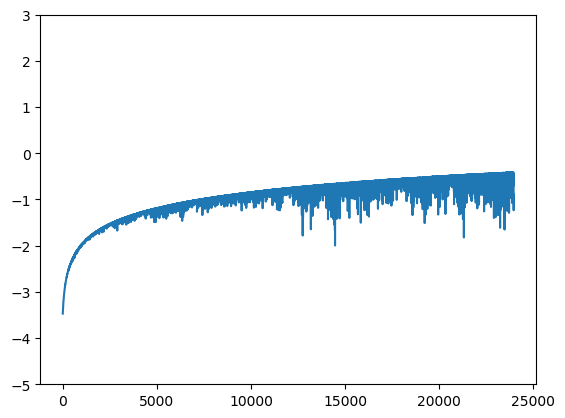

(-5, 3)

In [21]:
plt.plot([logpdf(Normal(x_μ_pred[k], x_σ_pred[k]), x_true[k]) for k = 1:length(x_true)])
plt.ylim(-5,3)